<a href="https://colab.research.google.com/github/kyle-gao/GRSS_TrackMSD2021/blob/main/MultiResUnetMCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Code from https://github.com/fengwang/MCNN/blob/master/tutorial/tutorial.ipynb

# A minimal MCNN example

Given an image of [Lenna](https://en.wikipedia.org/wiki/Lenna), we can simulate its second gradient with a [Laplace operator](https://en.wikipedia.org/wiki/Laplace_operator).

One of the ways for the simulation is an image convolution with a discrete kernel

\begin{vmatrix}
1&2&1\\
2&-12&2\\
1&2&1\\
\end{vmatrix}

This is straightforward and easy

In [1]:
import os
import shutil

In [2]:
!wget https://raw.githubusercontent.com/fengwang/MCNN/master/tutorial/images/lena.tif

--2021-03-03 16:21:05--  https://raw.githubusercontent.com/fengwang/MCNN/master/tutorial/images/lena.tif
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 524556 (512K) [image/tiff]
Saving to: ‘lena.tif’

lena.tif            100%[===================>] 512.26K  --.-KB/s    in 0.007s  

2021-03-03 16:21:05 (70.1 MB/s) - ‘lena.tif’ saved [524556/524556]



In [3]:
os.mkdir("./images")
shutil.copy("/content/lena.tif","./images/lena.tif")

'./images/lena.tif'

#Task: predict image from gradient

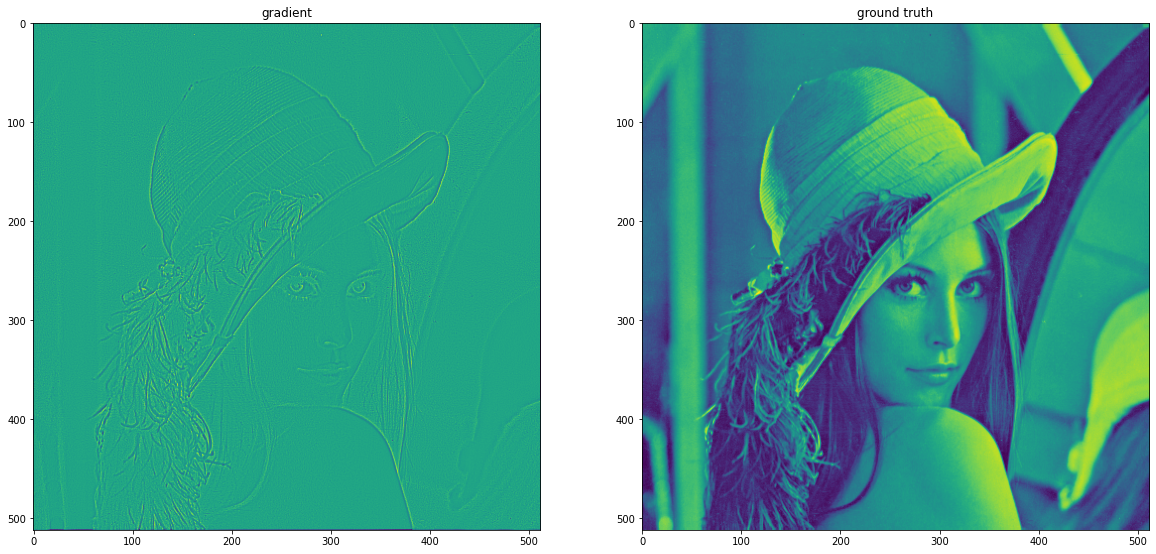

In [4]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

import tifffile
ground_truth = tifffile.imread( './images/lena.tif')

import numpy as np
kernel = np.asarray( [[1, 2, 1], [2, -12, 2], [1, 2, 1]], dtype='float32' )
ground_truth = (ground_truth-np.amin(ground_truth))/(np.amax(ground_truth)-np.amin(ground_truth))

from scipy.signal import convolve
gradient = convolve( ground_truth, kernel, mode='same' )

fig, axs = plt.subplots(1, 2)
axs[0].set_title('gradient')
axs[0].imshow(gradient)
axs[1].set_title('ground truth')
axs[1].imshow(ground_truth)
plt.show()

The phase problem involves reconstruction the original image from its gradient.
To solve this problem with deep convolutional neural networks, first we need to check if the framework [tensorflow](https://www.tensorflow.org) has been installed or not. This can be done by

In [5]:
import tensorflow
print( tensorflow.__version__)

2.4.1


Then we start to implement our MCNN model.
First we define our [kernel initializer](https://arxiv.org/abs/1502.01852) and regularizer

In [6]:
from tensorflow.python.keras import regularizers
from tensorflow.python.keras.initializers import he_normal
kr = regularizers.l2( 1.0e-3 )
ki = he_normal()

With `kr` and `ki`, we define the classic U-Net structure

In [7]:
from tensorflow.python.keras.layers import Input
from tensorflow.python.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers.merge import add

init = Input(shape=(512, 512, 1))
init_ = Conv2D( 32, kernel_size=(31, 31), activation = "relu", strides = 1, padding="same", kernel_regularizer=kr, kernel_initializer=ki )( init )
l1 = Conv2D( 64, kernel_size=(7, 7), activation = "relu", strides = 2, padding="same", kernel_regularizer=kr, kernel_initializer=ki )( init_ )
l2=Conv2D(128, kernel_size=(5, 5), activation="relu", strides=2, padding='same', kernel_regularizer=kr, kernel_initializer=ki)(l1) # 128
l3=Conv2D(192, kernel_size=(3, 3), activation="relu", strides=2, padding='same', kernel_regularizer=kr, kernel_initializer=ki)(l2) # 64
l4=Conv2D(256, kernel_size=(3, 3), activation="relu", strides=2, padding='same', kernel_regularizer=kr, kernel_initializer=ki)(l3) # 32
l5=Conv2D(384, kernel_size=(3, 3), activation="relu", strides=2, padding='same', kernel_regularizer=kr, kernel_initializer=ki)(l4) # 16
l6=Conv2D(512, kernel_size=(3, 3), activation="relu", strides=2, padding='same', kernel_regularizer=kr, kernel_initializer=ki)(l5) # 8
lx1=Conv2D(768, kernel_size=(3, 3), activation="relu", strides=(1,1), padding='valid', kernel_regularizer=kr, kernel_initializer=ki)(l6) # 6
lx1=Conv2D(1024, kernel_size=(3, 3), activation="relu", strides=(1,1), padding='valid', kernel_regularizer=kr, kernel_initializer=ki)(lx1) # 4
lx2=Conv2D(2048, kernel_size=(3, 3), activation="relu", strides=(1,1), padding='valid', kernel_regularizer=kr, kernel_initializer=ki)(lx1) # 2
lx3=Conv2DTranspose(1024, kernel_size=(3, 3), strides=(1,1), padding='valid', kernel_regularizer=kr, kernel_initializer=ki, activation="relu")(lx2) # 4
lx4=add([lx3, lx1])
lx5=Conv2DTranspose(768, kernel_size=(3, 3), strides=(1,1), padding='valid', kernel_regularizer=kr, kernel_initializer=ki, activation="relu")(lx4) # 6
l7=Conv2DTranspose(512, kernel_size=(3, 3), strides=(1,1), padding='valid', kernel_regularizer=kr, kernel_initializer=ki, activation="relu")(lx5) # 8
l9=add([l7, l6]) #
l10=Conv2DTranspose(384, kernel_size=(3, 3), strides=(2,2), padding='same', kernel_regularizer=kr, kernel_initializer=ki, activation="relu")(l9) # 16
l12=add([l10, l5]) #
l13=Conv2DTranspose(256, kernel_size=(3, 3),  activation="relu", strides=(2,2), padding='same', kernel_regularizer=kr, kernel_initializer=ki)(l12) # 32
l15=add([l13, l4]) #
l16=Conv2DTranspose(192, kernel_size=(3, 3), strides=(2,2), activation="relu", padding='same', kernel_regularizer=kr, kernel_initializer=ki)(l15) # 64
l18=add([l16, l3]) #
l19=Conv2DTranspose(128, kernel_size=(3, 3), activation="relu", strides=(2,2), padding='same', kernel_regularizer=kr, kernel_initializer=ki)(l18) # 128
l21=add([l19, l2]) #
l22=Conv2DTranspose(64, kernel_size=(3, 3), activation="relu", strides=(2,2), padding='same', kernel_regularizer=kr, kernel_initializer=ki)(l21) # 256
l24=add([l22, l1])
l25=Conv2DTranspose(32, kernel_size=(3, 3), activation="relu", strides=(2,2), padding='same', kernel_regularizer=kr, kernel_initializer=ki)(l24) # 512
l27=add([l25, init_])
llast=Conv2D(16 , kernel_size=(3, 3), activation='relu', strides=(1,1), padding='same', kernel_regularizer=kr, kernel_initializer=ki)(l27)
llast=Conv2D(8 , kernel_size=(3, 3), activation='relu', strides=(1,1), padding='same', kernel_regularizer=kr, kernel_initializer=ki)(llast)
last512=Conv2D(1, kernel_size=(31, 31), activation='sigmoid', strides=(1,1), padding='same', kernel_regularizer=kr, kernel_initializer=ki, name="gen_512")(llast)
#unet = Model( init, last512 )

MCNN epxands the layers in the decoder to match low-frequency components. The expanded layers can be defined this way to make a model

##Kyle: The following part takes intermediate 7 layer output lx4, lx8, lx16 etc... and passes them through 2 small conv2D layers (8 channels followed by 1 channel), combined with the final output layer, this generates seven single band images as output from large to small.The whole model takes a single image as input and generates 8 output images.

In [8]:
last4=Conv2D(8 , kernel_size=(3, 3), activation='relu', strides=(1,1), padding='same', kernel_regularizer=kr, kernel_initializer=ki)(lx4)
last4=Conv2D(1, kernel_size=(3, 3), activation='sigmoid', strides=(1,1), padding='same', kernel_regularizer=kr, kernel_initializer=ki, name="gen_4")(last4)

last8=Conv2D(8 , kernel_size=(3, 3), activation='relu', strides=(1,1), padding='same', kernel_regularizer=kr, kernel_initializer=ki)(l9)
last8=Conv2D(1, kernel_size=(5, 5), activation='sigmoid', strides=(1,1), padding='same', kernel_regularizer=kr, kernel_initializer=ki, name="gen_8")(last8)

last16=Conv2D(8 , kernel_size=(3, 3), activation='relu', strides=(1,1), padding='same', kernel_regularizer=kr, kernel_initializer=ki)(l12)
last16=Conv2D(1, kernel_size=(5, 5), activation='sigmoid', strides=(1,1), padding='same', kernel_regularizer=kr, kernel_initializer=ki, name="gen_16")(last16)

last32=Conv2D(8 , kernel_size=(3, 3), activation='relu', strides=(1,1), padding='same', kernel_regularizer=kr, kernel_initializer=ki)(l15)
last32=Conv2D(1, kernel_size=(7, 7), activation='sigmoid', strides=(1,1), padding='same', kernel_regularizer=kr, kernel_initializer=ki, name="gen_32")(last32)

last64=Conv2D(8 , kernel_size=(3, 3), activation='relu', strides=(1,1), padding='same', kernel_regularizer=kr, kernel_initializer=ki)(l18)
last64=Conv2D(1, kernel_size=(9, 9), activation='sigmoid', strides=(1,1), padding='same', kernel_regularizer=kr, kernel_initializer=ki, name="gen_64")(last64)

last128=Conv2D(8 , kernel_size=(3, 3), activation='relu', strides=(1,1), padding='same', kernel_regularizer=kr, kernel_initializer=ki)(l21)
last128=Conv2D(1, kernel_size=(11, 11), activation='sigmoid', strides=(1,1), padding='same', kernel_regularizer=kr, kernel_initializer=ki, name="gen_128")(last128)

last256=Conv2D(8 , kernel_size=(3, 3), activation='relu', strides=(1,1), padding='same', kernel_regularizer=kr, kernel_initializer=ki)(l24)
last256=Conv2D(1, kernel_size=(17, 17), activation='sigmoid', strides=(1,1), padding='same', kernel_regularizer=kr, kernel_initializer=ki, name="gen_256")(last256)

mcnn = Model(inputs=init, outputs=[last512, last256, last128, last64, last32, last16, last8, last4])
mcnn.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 32) 30784       input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 100416      conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 128 204928      conv2d_1[0][0]                   
______________________________________________________________________________________________

With 2 GPUs, we make the training plan using [Adam](https://arxiv.org/abs/1412.6980) minimizing the mean absolute errros

In [9]:
#from tensorflow.python.keras.utils import multi_gpu_model
#mcnn = multi_gpu_model( mcnn, gpus=2 )
mcnn.compile( loss='mae', optimizer='adam' )

The low frequency components data can be generated by pooling the original images sequencially. This is done by

In [10]:
from skimage.measure import block_reduce
def make_block_reduce( input_layers, dim=(2,2), mode=np.mean ):
    stacked_layers = [ block_reduce( image, dim, mode ) for image in input_layers ]
    return np.asarray( stacked_layers, dtype='float32' )

Then by simulating the gradient images from some existing image set, for example [ImageNet](http://www.image-net.org/), we can prepare a training/validation dataset with 1024 samples this way

In [11]:
#deep globe dataset in my google drive
!gdown --id 1T4BijZG0ZlIKOyhd9msxNmzbGnvsyyFo
shutil.unpack_archive("/content/DeepGlobe_512.zip","./DeepGlobe")

Downloading...
From: https://drive.google.com/uc?id=1T4BijZG0ZlIKOyhd9msxNmzbGnvsyyFo
To: /content/DeepGlobe_512.zip
597MB [00:06, 88.4MB/s]


In [12]:
import glob
paths = glob.glob( '/content/DeepGlobe/*.jpg')

import random    
random.shuffle( paths )

shape = (512, 512)
number = 1024
gaussian_noise_var = 0.01

from imageio import imread
def trim_image_from_path( image_path, shape ):
    try:
        image = imread( image_path )
    except:
        return None
    image = np.asarray( image, dtype='float32' )
    image = image / 255.0

    if 3 == len(image.shape): # rgb -> gray
        image = 0.2627*image[:,:,0]+0.6780*image[:,:,1]+0.0593*image[:,:,2]

    scaling_ratio = [ int(a/b) for a, b in zip( image.shape, shape ) ]
    if scaling_ratio[0] > 1 and scaling_ratio[1] > 1 :
        image = block_reduce( image, tuple(scaling_ratio), np.mean )

    dim_diff = [ (a - b)>>1 for a, b in zip( image.shape, shape ) ]
    if dim_diff[0] < 0 or dim_diff[1] < 0:
        return None
    return image[dim_diff[0]:dim_diff[0]+shape[0], dim_diff[1]:dim_diff[1]+shape[1]]

output_images = []
input_images = []
counter = 0
for path in paths:
    trimmed_image = trim_image_from_path(path, shape )
    if trimmed_image is not None:
        print( f'preparing training set from {path} - {counter}/{number}', end='\r' )
        output_images.append(trimmed_image)
        input_images.append( convolve( trimmed_image, kernel, mode='same' ) )
        counter += 1
    if counter == number:
        break

input_layers = np.asarray( input_images, dtype='float32' ).reshape( (number,)+shape+(1,) )
input_layers += np.random.normal(loc=0.0, scale=gaussian_noise_var, size=input_layers.shape)
#input_layers = ( input_layers-np.mean(input_layers) ) / (np.std(input_layers) + 1.0e-10)

output_layers = [np.asarray( output_images, dtype='float32' ), None, None, None, None, None, None, None]
for idx in range( 7 ):
    output_layers[idx+1] = make_block_reduce( output_layers[idx], (2,2), np.mean )
    output_layers[idx] = output_layers[idx].reshape( output_layers[idx].shape + (1,) )
output_layers[7] = output_layers[7].reshape( output_layers[7].shape + (1,) )

The gradient and the ground truth for the first image-pair are visualized below

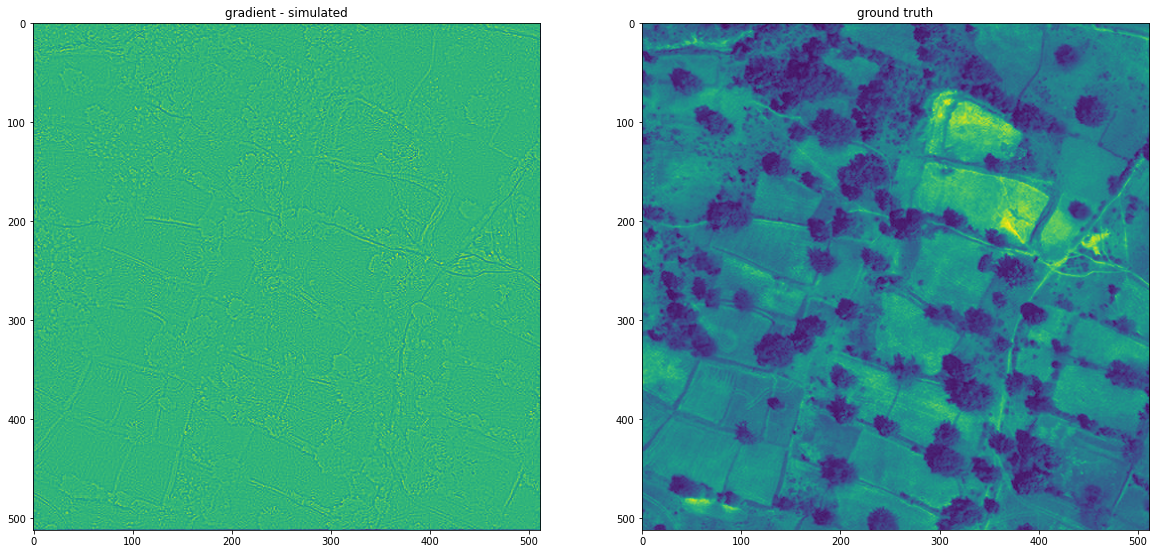

In [13]:
fig, axs = plt.subplots(1, 2)
axs[0].set_title('gradient - simulated')
axs[0].imshow(np.squeeze(input_layers[0]))
axs[1].set_title('ground truth')
axs[1].imshow(np.squeeze(output_layers[0][0]))
plt.rcParams["figure.figsize"] = (20,10)
plt.show()

With a simple training history recoder

For demonstration, we train the model 128 epochs with a batch size of 8 and a validation split of 1/4. In actural applications, the epochs and the size of the training set should be much larger.

In [14]:
input_layers.shape

(1024, 512, 512, 1)

In [15]:
for o in output_layers:
  print (o.shape)

(1024, 512, 512, 1)
(1024, 256, 256, 1)
(1024, 128, 128, 1)
(1024, 64, 64, 1)
(1024, 32, 32, 1)
(1024, 16, 16, 1)
(1024, 8, 8, 1)
(1024, 4, 4, 1)


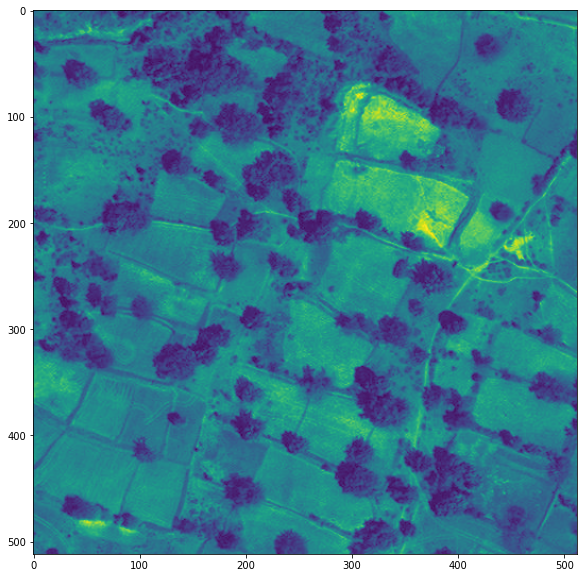

In [16]:
plt.imshow(output_layers[0][0,:,:,0])

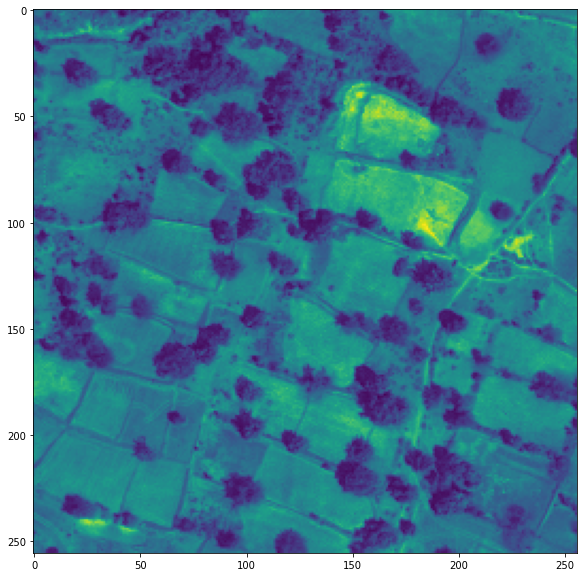

In [17]:
plt.imshow(output_layers[1][0,:,:,0])

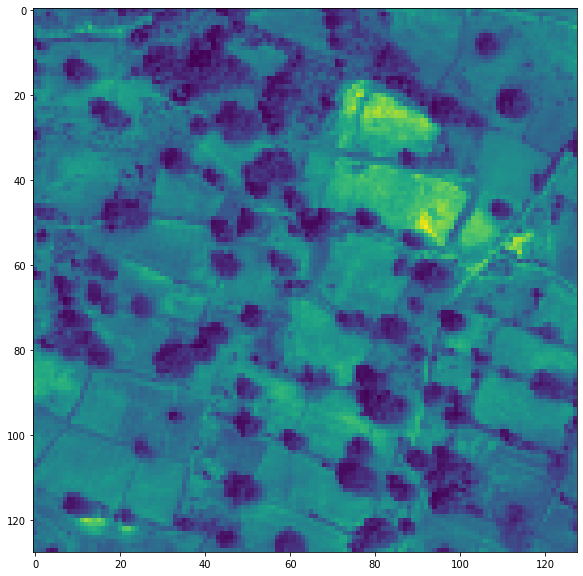

In [18]:
plt.imshow(output_layers[2][0,:,:,0])

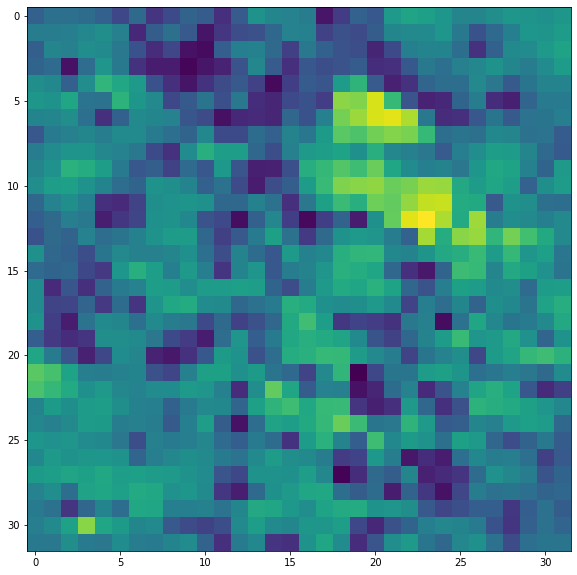

In [19]:
plt.imshow(output_layers[4][0,:,:,0])

##Kyle: The training target is 8 images: the original target + 7 other target whose resolution have been artificially lowered
##Tensorflow treats this as computing 8 separate losses which are then averaged to create a final loss function which is the optimization target. See https://github.com/keras-team/keras/blob/9118ea65f40874e915dd1299efd1cc3a7ca2c333/keras/engine/training.py#L816-L848

In [20]:
mcnn.fit( input_layers, output_layers, batch_size=8, epochs=5, verbose=1,validation_split=0.25 )

Epoch 1/5
96/96 [==============================] - 342s 2s/step - loss: 11.8036 - gen_512_loss: 0.1526 - gen_256_loss: 0.1297 - gen_128_loss: 0.1264 - gen_64_loss: 0.1256 - gen_32_loss: 0.1320 - gen_16_loss: 0.1235 - gen_8_loss: 0.1252 - gen_4_loss: 0.1251 - val_loss: 2.0103 - val_gen_512_loss: 0.1110 - val_gen_256_loss: 0.1078 - val_gen_128_loss: 0.1052 - val_gen_64_loss: 0.1012 - val_gen_32_loss: 0.0977 - val_gen_16_loss: 0.0919 - val_gen_8_loss: 0.0855 - val_gen_4_loss: 0.0802
Epoch 2/5
96/96 [==============================] - 206s 2s/step - loss: 1.6600 - gen_512_loss: 0.1074 - gen_256_loss: 0.1054 - gen_128_loss: 0.1029 - gen_64_loss: 0.0991 - gen_32_loss: 0.0958 - gen_16_loss: 0.0904 - gen_8_loss: 0.0839 - gen_4_loss: 0.0778 - val_loss: 1.1426 - val_gen_512_loss: 0.1111 - val_gen_256_loss: 0.1095 - val_gen_128_loss: 0.1065 - val_gen_64_loss: 0.1019 - val_gen_32_loss: 0.0983 - val_gen_16_loss: 0.0933 - val_gen_8_loss: 0.0859 - val_gen_4_loss: 0.0803
Epoch 3/5
96/96 [==============

The training will take quite a while depending on the hardware.

After training, we can make a prediction to test

In [21]:
prediction, *_ = mcnn.predict( gradient.reshape((1,)+gradient.shape+(1,)))
prediction = np.squeeze( prediction )

Now we can compare the ground truth and the prediction

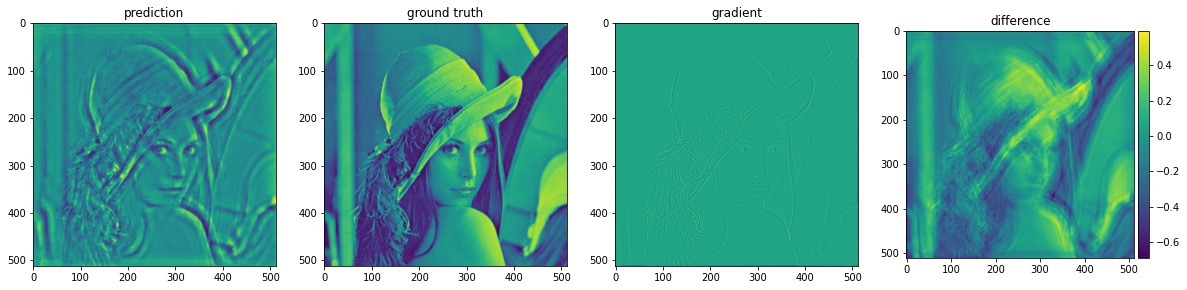

MAE is 0.15815738231542248


In [22]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, axs = plt.subplots(1, 4)
axs[0].set_title('prediction')
axs[0].imshow(prediction)
axs[1].set_title('ground truth')
axs[1].imshow(ground_truth)
axs[2].set_title('gradient')
axs[2].imshow(gradient)
ground_truth = (ground_truth-np.amin(ground_truth))/(np.amax(ground_truth)-np.amin(ground_truth)+1.0e-10)
prediction = (prediction-np.amin(prediction))/(np.amax(prediction)-np.amin(prediction)+1.0e-10)
diff = ground_truth - prediction
axs[3].set_title('difference')
im = axs[3].imshow(diff)
divider = make_axes_locatable(axs[3])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
plt.rcParams["figure.figsize"] = (20,10)
plt.show()

print( f'MAE is {np.sum(np.abs(diff))/(512*512)}' )
